In [127]:
from datetime import datetime, timedelta
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [128]:
# Function to parse job time string to timedelta
def parse_job_time(job_time_str):
    hours, minutes, seconds = map(int, job_time_str.split(':'))
    return timedelta(hours=hours, minutes=minutes, seconds=seconds)


# Function to parse the start time string to datetime
def parse_start_time(job_time_str):
    return datetime.strptime(job_time_str, '%Y-%m-%d %H:%M:%S')


# Function to get the job times for each benchmark (in seconds), for all runs (files)
def get_batch_times(files):
    # Create a dictionary with all the key-values : job_name --> [t1, t2, t3]
    batch_execution_times = {}
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Job:'):
                    batch_name = line.split(': ')[1].strip()
                elif line.startswith('Job time:'):
                    job_time_str = line.split(': ')[1].strip()
                    job_time = parse_job_time(job_time_str)
                    if batch_name in batch_execution_times:
                        batch_execution_times[batch_name].append(job_time.total_seconds())
                    else:
                        batch_execution_times[batch_name] = [job_time.total_seconds()]
    return batch_execution_times


# Function to calculate mean and standard deviation of job time for each batch application
def calculate_batch_means_and_stds(files):
    batch_execution_times = get_batch_times(files)
    # Create mean and std dictionaries with all key-values: job_name --> mean and job_name --> std
    batch_means = {}
    batch_stds = {}
    for batch_name, execution_times in batch_execution_times.items():
        batch_means[batch_name] = statistics.mean(execution_times)
        batch_stds[batch_name] = statistics.stdev(execution_times)

    return batch_means, batch_stds


# Function to get the total job time (in seconds) for each file
def get_total_job_times(files):
    job_times = list()
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Total time:'):
                    job_time = parse_job_time(line.split(': ')[1].strip())
                    job_times.append(job_time.total_seconds())
    return job_times


# Function to calculate relative starting times in seconds for each job
def calculate_relative_start_times(files):
    relative_start_times = list()
    for file in files:
        start_times = list()
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Start time:'):
                    start_time = parse_start_time(line.split(': ')[1].strip())
                    start_times.append(start_time)
        min_start_time = min(start_times)
        relative_start_times.append([(start_time - min_start_time).total_seconds() for start_time in start_times])
    
    return relative_start_times


# Function to parse ts_start and ts_end to datetime objects
def parse_timestamp(timestamp_str):
    return datetime.fromtimestamp(int(timestamp_str) / 1000)


# Function to parse the mcperf file
def parse_mcperf_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    
    header = lines[0].split()
    column_indices = {header[i]: i for i in range(len(header))} # To get automatically the correct columns instead of hardcoding indeces
    data = {'p95': [], 'QPS':[], 'target':[], 'ts_start': [], 'ts_start_timestamp': [], 'ts_end': []}
    for line in lines[1:]:  # To skip the header line
        parts = line.split()
        data['p95'].append(float(parts[column_indices['p95']]))
        data['QPS'].append(float(parts[column_indices['QPS']]))
        data['target'].append(float(parts[column_indices['target']]))
        data['ts_start'].append(parse_timestamp(parts[column_indices['ts_start']]) - timedelta(hours=2))
        data['ts_start_timestamp'].append(int(parts[column_indices['ts_start']])/1000)
        data['ts_end'].append(parse_timestamp(parts[column_indices['ts_end']]) - timedelta(hours=2))

    df = pd.DataFrame(data)
    return df


# Function to synchronize mcperf timestamps with container's job timestamps !
def synch_mcperf_pods(df, pod_file):
        start_times = list()
        end_times = list()
        stime = False
        jtime = False
        with open(pod_file, 'r') as f:
            for line in f:
                if line.startswith('Start time:'):
                        start_time = parse_start_time(line.split(': ')[1].strip())
                        start_times.append(start_time)
                        stime = True
                if line.startswith('Job time:'):
                        job_duration = parse_job_time(line.split(': ')[1].strip())
                        jtime = True
                
                if stime and jtime:
                        end_time = (start_time + job_duration)
                        end_times.append(end_time)
                        stime = False
                        jtime = False
    
        min_start_time = min(start_times)
        max_end_time = max(end_times)
        
        # timedelta(seconds=3) for having nice bars before and after PARSEC makespan start/end points
        closest_start = df[df['ts_start'] <= (min_start_time - timedelta(seconds=3))]['ts_start'].max()
        closest_start_index = df[df['ts_start'] == closest_start].index[0]
        closest_end = df[df['ts_end'] >= (max_end_time + timedelta(seconds=3))]['ts_end'].min()
        closest_end_index = df[df['ts_end'] == closest_end].index[0]

        start_offset = min_start_time - closest_start
        end_offset = closest_end - max_end_time
        
        df = df.loc[closest_start_index:closest_end_index]
        
        #print("Total seconds: ", start_offset.total_seconds())
        
        return df, start_offset.total_seconds(), end_offset.total_seconds()


# Function to arrange times in a format convenient for plotting
def arrange_times(batch_times, total_times, n_runs):
    arranged_times = list()
    for i in range(n_runs):
        tmp = list()
        for value in batch_times.values():
            tmp.append(value[i])
        tmp.append(total_times[i])
        arranged_times.append(tmp)
    return arranged_times


# Compute SLO violation ration for a given run
def compute_SLO_violation_ratio(p95):
    return (p95/1000.0 > 1).sum() / len(p95)

In [131]:
files = ["measurements/pods_1.txt", "measurements/pods_2.txt", "measurements/pods_3.txt"]
mcperf_files = ["measurements/mcperf_1.txt", "measurements/mcperf_2.txt", "measurements/mcperf_3.txt"]
n_runs = 3

In [132]:
# Calculate batch means and standard deviations
batch_means, batch_stds = calculate_batch_means_and_stds(files)

print('Batch Application Means:')
for batch_name, mean in batch_means.items():
    print(f'- {batch_name}: {mean:.2f} seconds')

print('\nBatch Application Standard Deviations:')
for batch_name, std in batch_stds.items():
    print(f'- {batch_name}: {std:.2f} seconds')

# Get total job times (in seconds) for each file and convert them to seconds
total_job_times = get_total_job_times(files)
print('\nTotal Job Time Across All Files:', total_job_times)

# Calculate mean and standard deviation of the total time to complete all jobs (makespan)
makespan_mean = statistics.mean(total_job_times)
makespan_stdev = statistics.stdev(total_job_times)
print(f'\nMakespan Mean: {makespan_mean:.2f} seconds')
print(f'Makespan Standard Deviation: {makespan_stdev:.2f} seconds')

Batch Application Means:
- parsec-blackscholes: 114.33 seconds
- parsec-canneal: 139.33 seconds
- parsec-dedup: 10.33 seconds
- parsec-ferret: 94.33 seconds
- parsec-freqmine: 140.67 seconds
- parsec-radix: 10.00 seconds
- parsec-vips: 29.33 seconds

Batch Application Standard Deviations:
- parsec-blackscholes: 1.15 seconds
- parsec-canneal: 0.58 seconds
- parsec-dedup: 0.58 seconds
- parsec-ferret: 0.58 seconds
- parsec-freqmine: 0.58 seconds
- parsec-radix: 0.00 seconds
- parsec-vips: 0.58 seconds

Total Job Time Across All Files: [153.0, 154.0, 154.0]

Makespan Mean: 153.67 seconds
Makespan Standard Deviation: 0.58 seconds


In [133]:

# Get the batch times and the total times across all runs
batch_times = get_batch_times(files)
total_times = get_total_job_times(files)

# Arrange times for convenient plotting
arranged_times = arrange_times(batch_times, total_times, n_runs)

# Get dataframes of interest from mcperf files and compute memcached timespan
mcperf_dfs = list()
start_offsets = list()
end_offsets = list()
for pod_file, mcperf_file in zip(files, mcperf_files):
    df = parse_mcperf_file(mcperf_file)
    df, start_offset, end_offset = synch_mcperf_pods(df, pod_file)
    start_offsets.append(start_offset)
    end_offsets.append(end_offset)
    df['ts_span'] = (df['ts_end'] - df['ts_start']).dt.total_seconds()
    df = df[['p95', 'QPS', 'target', 'ts_start', 'ts_start_timestamp', 'ts_span']]
    mcperf_dfs.append(df)
    
# Get the relative job time spans wrt the first run job(s)
relative_start_times = calculate_relative_start_times(files)

# Get the SLO violation ratios
violation_ratios = list()
for file in mcperf_files:
    df = parse_mcperf_file(file)
    violation_ratios.append(compute_SLO_violation_ratio(df['p95']))
print('Violation Ratios: ', violation_ratios)

Violation Ratios:  [0.0, 0.0, 0.0]


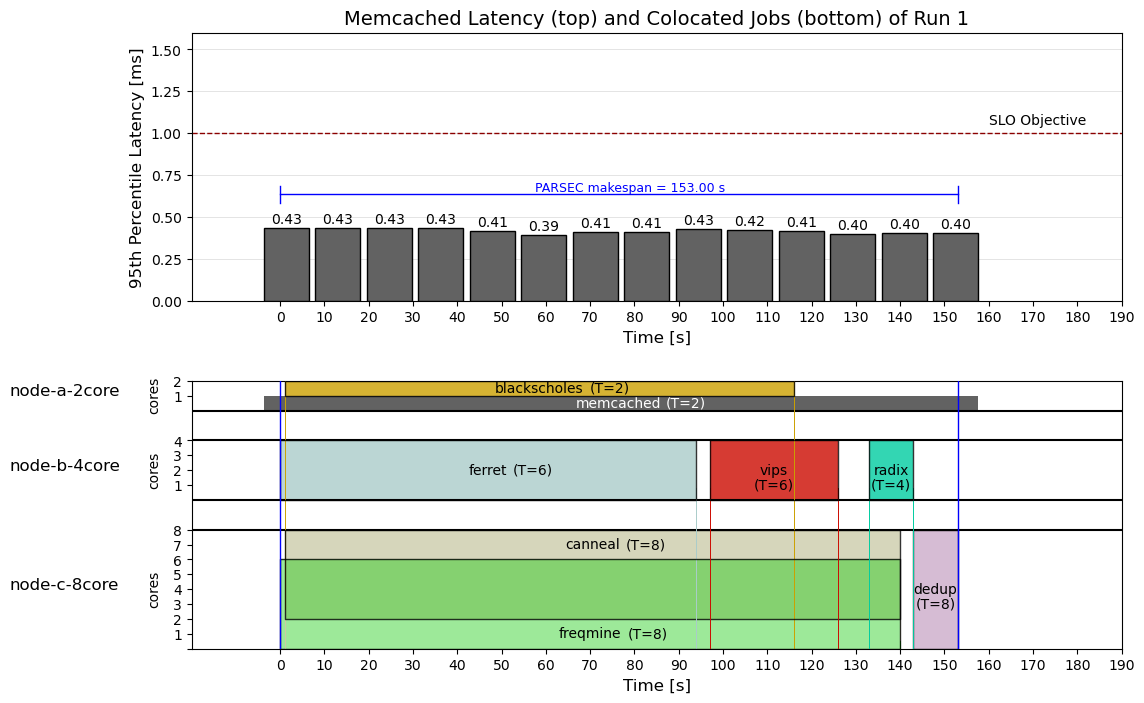

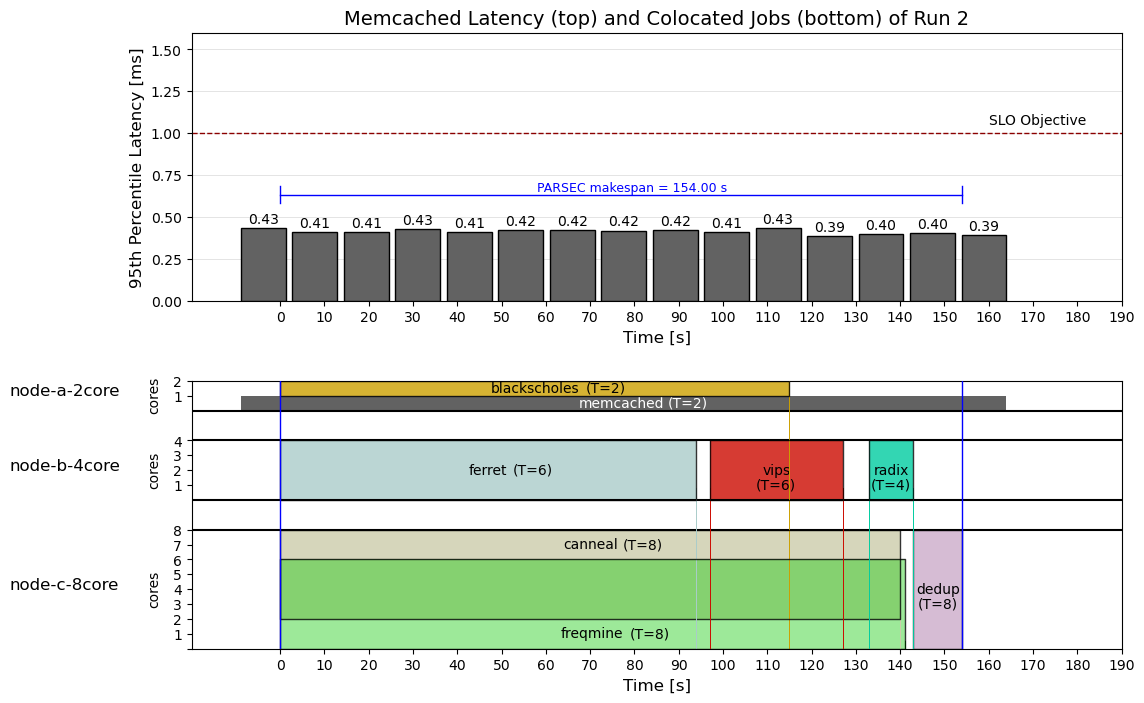

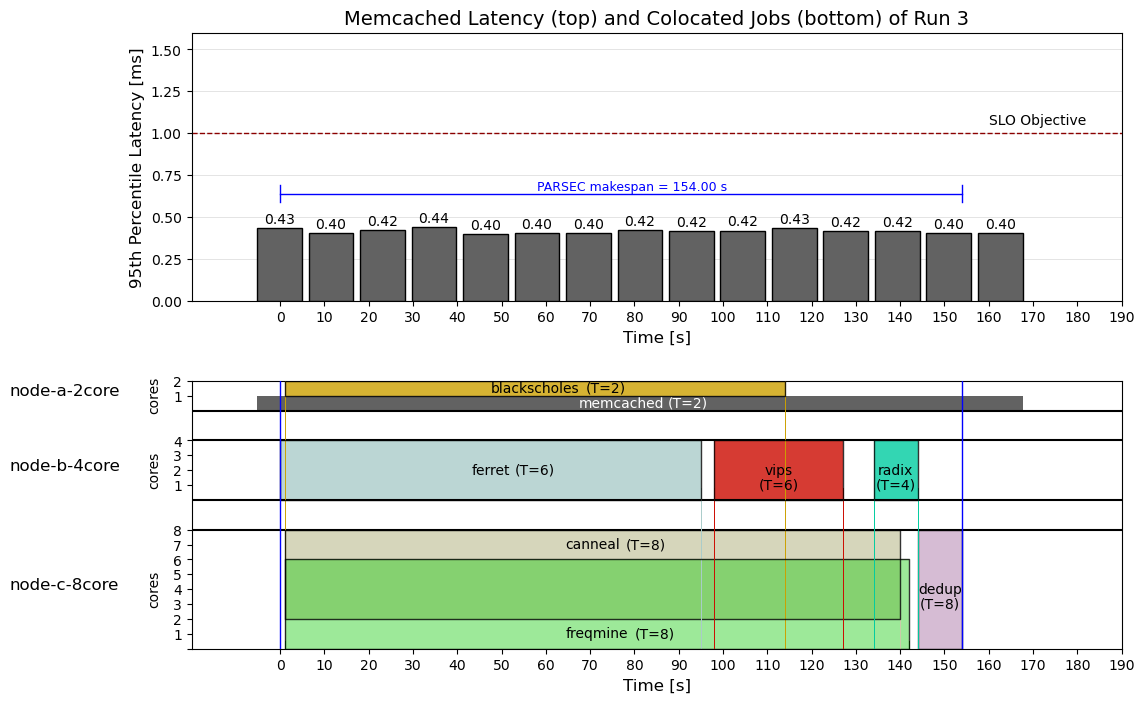

In [136]:
# Create plot 3a
colors = {'canneal': '#CCCCAA', 'dedup': '#CCACCA', 'blackscholes': '#CCA000',
          'ferret': '#AACCCA', 'freqmine': '#0CCA00',
          'memcached': '#626262', 'radix': '#00CCA0', 'vips': '#CC0A00'}
jobs = ['blackscholes', 'canneal', 'dedup', 'ferret', 'freqmine', 'radix', 'vips']
jobs_pos_hbars = [(17, 1), (2, 6), (0, 8), (10, 4), (0, 6), (10, 4), (10, 4)]
jobs_pos_annotations = [17.5, 7, 4, 12, 1, 12, 12]
start_job_ann_yoffsets = {
    'blackscholes': -4,
    'canneal': -3,
    'dedup': -4,
    'ferret': -2,
    'freqmine': -1,
    'radix': -2.5,
    'vips': -3
}
end_job_ann_yoffsets = {
    'blackscholes': -3.5,
    'canneal': -3,
    'dedup': -2.5,
    'ferret': -2,
    'freqmine': -1.5,
    'radix': -3.5,
    'vips': -1.5
}

for i, df in enumerate(mcperf_dfs):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), dpi=100)
    fig.subplots_adjust(hspace=0.3)
    
    ## ------ First Subplot ------ ##
    x = (df['ts_start_timestamp'] - df['ts_start_timestamp'].min()) - start_offsets[i]
    y = df['p95']/1000.0
    bars = ax1.bar(x, y, width=df['ts_span'], color=colors['memcached'], edgecolor='black', linewidth=1, align='edge', zorder=3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=10
    )
    slo_objective = ax1.axhline(y=1, color='darkred', linestyle='--', linewidth=1)
    ax1.annotate('SLO Objective', xy=(160, 1.05), color='black')
    ax1.plot([0, total_times[i]], [y.max() + 0.2, y.max() + 0.2], color='blue', linestyle='-', linewidth=1)
    ax1.plot([0, 0], [y.max() + 0.15, y.max() + 0.25], color='blue', linestyle='-', linewidth=1)
    ax1.plot([total_times[i], total_times[i]], [y.max() + 0.15, y.max() + 0.25], color='blue', linestyle='-', linewidth=1)
    ax1.annotate(f'PARSEC makespan = {total_times[i]:.2f} s', xy=(total_times[i]/2-len(f'makespan = {total_times[i]:.2f} s'), y.max() + 0.22), color='blue', fontsize=9)
    
    # Style
    ax1.set_xlim((-20, 190))
    ax1.set_xticks(list(range(0, 191, 10)))
    ax1.set_xlabel("Time [s]", fontsize = 12)
    
    ax1.set_ylim((0, 1.6))
    ax1.set_yticks(np.arange(0, 1.75, 0.25).tolist())
    ax1.set_ylabel('95th Percentile Latency [ms]', fontsize = 12)
    
    ax1.set_title('Memcached Latency (top) and Colocated Jobs (bottom) of Run ' + str(i+1), fontsize = 14)
    ax1.grid(axis='y', color='grey', linewidth=0.5, alpha=0.3, zorder=1)
    
    ## ------ Second Subplot ------ ##
    # Memcached
    ax2.broken_barh([(0 - start_offsets[i], start_offsets[i] + total_times[i] + end_offsets[i])], (16, 1), facecolors = colors['memcached'], zorder=0)
    ax2.annotate('memcached', (total_times[i]/2, 16.5), color = 'white', 
                 horizontalalignment='center', verticalalignment='center')
    
    # In order of appearance in pods_{i}.txt (as in arranged_times and relative_start_times):
    for idx, job in enumerate(jobs):
        
        start_time = relative_start_times[i][jobs.index(job)]
        duration = arranged_times[i][jobs.index(job)]
        end_time = start_time + duration
        ypos = jobs_pos_hbars[jobs.index(job)][0] + 0.5
        
        ax2.axvline(x=start_time, ymin=0, ymax=ypos/17.5, color=colors[job], linestyle='-', linewidth=0.7, zorder=7)
        ax2.axvline(x=end_time, ymin=0, ymax=ypos/17.5, color=colors[job], linestyle='-', linewidth=0.7, zorder=7)
        
        #ax2.text(start_time, start_job_ann_yoffsets[job], f'{round(start_time)}', va='top', color=colors[job], fontsize=10)
        #ax2.text(end_time, end_job_ann_yoffsets[job], f'{round(end_time)}', va='top', color=colors[job], fontsize=10)
        
        if job == 'freqmine':
            alph = 0.4
        else:
            alph = 0.8
            
        # Bars without border
        ax2.broken_barh([(start_time, duration)],
                        jobs_pos_hbars[jobs.index(job)],
                        facecolors=colors[job], edgecolor='none', alpha=alph, zorder=2)

        # Only bar edges 
        ax2.broken_barh([(start_time, duration)],
                        jobs_pos_hbars[jobs.index(job)],
                        facecolors='none', edgecolor='black', linewidth=1, alpha=0.8, zorder=7)
        
        ax2.annotate(job, 
                     ((relative_start_times[i][jobs.index(job)]*2 + arranged_times[i][jobs.index(job)])/2, 
                     jobs_pos_annotations[jobs.index(job)]), color = 'black', horizontalalignment='center', 
                     verticalalignment='center', zorder=5)
    
    # Annotate with #threads
    # memcached
    ax2.annotate('(T=2)', (total_times[i]/2 + len('memcached') + 6, 16.5), color = 'white', 
                 horizontalalignment='center', verticalalignment='center')
        
    # blackscholes
    ax2.annotate('(T=2)', 
                ((relative_start_times[i][jobs.index('blackscholes')]*2 + arranged_times[i][jobs.index('blackscholes')])/2 + len('blackscholes') + 4, 
                jobs_pos_annotations[jobs.index('blackscholes')]), color = 'black', horizontalalignment='center', 
                verticalalignment='center', zorder=8)
    # canneal
    ax2.annotate('(T=8)', 
            ((relative_start_times[i][jobs.index('canneal')]*2 + arranged_times[i][jobs.index('canneal')])/2 + len('canneal') + 5, 
            jobs_pos_annotations[jobs.index('canneal')]), color = 'black', horizontalalignment='center', 
            verticalalignment='center', zorder=8)
    # dedup
    ax2.annotate('(T=8)', 
            ((relative_start_times[i][jobs.index('dedup')]*2 + arranged_times[i][jobs.index('dedup')])/2, 
            jobs_pos_annotations[jobs.index('dedup')]-1), color = 'black', horizontalalignment='center', 
            verticalalignment='center', zorder=8)
    # ferret
    ax2.annotate('(T=6)', 
            ((relative_start_times[i][jobs.index('ferret')]*2 + arranged_times[i][jobs.index('ferret')])/2 + len('ferret') + 4, 
            jobs_pos_annotations[jobs.index('ferret')]), color = 'black', horizontalalignment='center', 
            verticalalignment='center', zorder=8)
    # freqmine
    ax2.annotate('(T=8)', 
            ((relative_start_times[i][jobs.index('freqmine')]*2 + arranged_times[i][jobs.index('freqmine')])/2 + len('freqmine') + 5, 
            jobs_pos_annotations[jobs.index('freqmine')]), color = 'black', horizontalalignment='center', 
            verticalalignment='center', zorder=8)
    # radix
    ax2.annotate('(T=4)', 
        ((relative_start_times[i][jobs.index('radix')]*2 + arranged_times[i][jobs.index('radix')])/2, 
        jobs_pos_annotations[jobs.index('radix')]-1), color = 'black', horizontalalignment='center', 
        verticalalignment='center', zorder=8)
    # vips
    ax2.annotate('(T=6)', 
        ((relative_start_times[i][jobs.index('vips')]*2 + arranged_times[i][jobs.index('vips')])/2, 
        jobs_pos_annotations[jobs.index('vips')]-1), color = 'black', horizontalalignment='center', 
        verticalalignment='center', zorder=8)

    # Style
    ax2.set_xlim((-20, 190))
    ax2.set_xticks(list(range(0, 191, 10)))
    ax2.set_xlabel("Time [s]", fontsize = 12)
    
    ax2.set_ylim(0, 18)
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18])
    ax2.set_yticklabels(['', '1', '2', '3', '4', '5', '6', '7', '8', '1', '2', '3', '4', '1', '2'])
    
    ax2.grid(False)
    ax2.axhline(y=8, color='black', linestyle='-', zorder=6)
    ax2.axhline(y=10, color='black', linestyle='-', zorder=6)
    ax2.axhline(y=14, color='black', linestyle='-', zorder=6)
    ax2.axhline(y=16, color='black', linestyle='-', zorder=6)
    ax2.axvline(x=0, color='blue', linestyle='-', linewidth=1, zorder=8)
    ax2.axvline(x=total_times[i], color='blue', linestyle='-', linewidth=1, zorder=8)
    #ax2.axvline(x=0, color='blue', linestyle=(0, (10, 8)), linewidth=1)
    #ax2.axvline(x=total_times[i], color='blue', linestyle=(0, (10, 8)), linewidth=1)
    
    ax2.text(-61, 4, 'node-c-8core', rotation=0, fontsize=12)
    ax2.text(-30, 3, 'cores', rotation=90, fontsize=10)
    
    ax2.text(-61, 12, 'node-b-4core', rotation=0, fontsize=12)
    ax2.text(-30, 11, 'cores', rotation=90, fontsize=10)
    
    ax2.text(-61, 17, 'node-a-2core', rotation=0, fontsize=12)
    ax2.text(-30, 16, 'cores', rotation=90, fontsize=10)
    
    plt.show()
    #plt.savefig("plot_" + str(i) + ".pdf", bbox_inches = "tight")